Text(0, 0.5, 'Water table depth (m)')

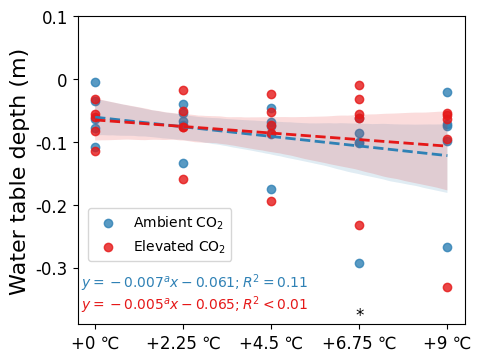

In [1]:
# water table change with warming and eCO2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import ttest_rel

import statsmodels.api as sm
import statsmodels.formula.api as smf

# def cal_reg_diff(x1, y1, x2, y2): # justify if there is significant difference between two groups data
#     # create two group datasets
#     x = np.concatenate([x1, x2])
#     y = np.concatenate([y1, y2])
#     group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

#     # create a model include interactive object
#     data = {'y': y, 'x': x, 'group': group}
#     model = smf.ols('y ~ x + group + x * C(group)', data=data).fit()

#     pvalue_diff_slope     = model.pvalues['x:C(group)[T.2]']
#     pvalue_diff_intercept = model.pvalues['C(group)[T.2]']

#     if pvalue_diff_slope < 0.05:
#         res_ab_slope = ("a", "b")
#     else:
#         res_ab_slope = ("a", "a")

#     if pvalue_diff_intercept < 0.05:
#         res_ab_intercept = ("a", "b")
#     else:
#         res_ab_intercept = ("a", "a")

#     return res_ab_slope, res_ab_intercept

def cal_reg_diff(x1, y1, x2, y2, alpha=0.05):
    # stack data
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

    # make DataFrame and enforce categorical with fixed ordering
    df = pd.DataFrame({'y': y, 'x': x, 'group': group})
    df['group'] = pd.Categorical(df['group'], categories=[1, 2])

    # fit model with interaction; treatment coding uses group==1 as reference
    model = smf.ols('y ~ x * C(group)', data=df).fit()

    # terms exist with these names under the setup above
    p_slope = model.pvalues['x:C(group)[T.2]']       # slope difference
    p_inter = model.pvalues['C(group)[T.2]']         # intercept difference

    res_ab_slope = ("a", "b") if p_slope < alpha else ("a", "a")
    res_ab_inter = ("a", "b") if p_inter < alpha else ("a", "a")

    return res_ab_slope, res_ab_inter#, model

# load data
# import pickle
# with open("2_results/4_water_table/r1_water_table_all_yr_june.pkl", "rb") as f:
#     data = pickle.load(f, encoding="latin1")  # 或 encoding='bytes'

# df_all_yr = data # pd.read_pickle("2_results/4_water_table/r1_water_table_all_yr_june.pkl")

import sys, types, numpy as np

# 创建伪造模块层级，让旧 pickle 能找到 numpy._core.numeric
np_core = types.ModuleType("numpy._core")
np_core.numeric = np
sys.modules["numpy._core"] = np_core
sys.modules["numpy._core.numeric"] = np

import pandas as pd
df_all_yr = pd.read_parquet("5_water_table/water_table_all_yr.parquet")

df_all_yr_used = df_all_yr[df_all_yr["year"]>2016].copy().reset_index()
# df_all_yr_used = df_all_yr.copy().reset_index()

ls_aco2_plots = ["P06", "P20", "P13", "P08", "P17"]
ls_eco2_plots = ["P19", "P11", "P04", "P16", "P10"]
ls_warmings   = [0,     2.25,  4.5,   6.75,  9]

fig, ax = plt.subplots(figsize=(5,4))
ls_colors = ["#2F81B5", "#E51818"]

y_lim = (-0.39, 0.1)
ax.set_ylim(y_lim)

ls_x_aco2 = []
ls_y_aco2 = []
ls_x_eco2 = []
ls_y_eco2 = []
for idx_warm, warming in enumerate(ls_warmings):
    y_aco2 = df_all_yr_used[df_all_yr_used["plot"]==ls_aco2_plots[idx_warm]]["zwt"].values
    x_aco2 = np.zeros(len(y_aco2))+warming

    ls_x_aco2.extend(x_aco2)
    ls_y_aco2.extend(y_aco2)
    # -------------------------------------
    y_eco2 = df_all_yr_used[df_all_yr_used["plot"]==ls_eco2_plots[idx_warm]]["zwt"].values
    x_eco2 = np.zeros(len(y_eco2))+warming
    ls_x_eco2.extend(x_eco2)
    ls_y_eco2.extend(y_eco2)
    # -------------------------------------
    t_stat, p_value = ttest_rel(y_aco2, y_eco2)
    mark_p = ""
    if   p_value<0.05:  mark_p = "*"
    elif p_value<0.01:  mark_p = "**"
    elif p_value<0.001: mark_p = "***"
    # -------------------------------------
    ax.text(warming, y_lim[0], mark_p, va="bottom", ha="center", fontsize=12)

res_ab_slope, res_ab_intercept = cal_reg_diff(ls_x_aco2, ls_y_aco2, ls_x_eco2, ls_y_eco2)


slope, intercept, r, p, stderr = linregress(ls_x_aco2, ls_y_aco2)
line_style = "-" if p < 0.05 else "--"
sns.regplot(x=ls_x_aco2, y=ls_y_aco2,
        scatter_kws={"color": ls_colors[0], "alpha": 0.8}, ax=ax, label="Ambient CO$_2$",
        line_kws={"color": ls_colors[0], "linestyle": line_style, "linewidth": 2})
ax.text(0.01, 0.12, f"$y = {slope:.3f}^{res_ab_slope[0]}x-{-intercept:.3f}; R^2={r*r:.2f}$", fontsize=10, color=ls_colors[0], transform=ax.transAxes)

slope, intercept, r, p, stderr = linregress(ls_x_eco2, ls_y_eco2)
line_style = "-" if p < 0.05 else "--"
sns.regplot(x=ls_x_eco2, y=ls_y_eco2,
        scatter_kws={"color": ls_colors[1], "alpha": 0.8}, ax=ax,label="Elevated CO$_2$",
        line_kws={"color": ls_colors[1], "linestyle": line_style, "linewidth": 2})
ax.text(0.01, 0.05, f"$y = {slope:.3f}^{res_ab_slope[1]}x-{-intercept:.3f}; R^2 < 0.01$", fontsize=10, color=ls_colors[1], transform=ax.transAxes)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

custom_x_ticks  = [0,      2.25,    4.5,    6.75,    9]  # x stick
custom_x_labels = ['+0 ℃', '+2.25 ℃', '+4.5 ℃', '+6.75 ℃', '+9 ℃']
ax.set_xticks(custom_x_ticks)
ax.set_xticklabels(custom_x_labels)

ax.set_yticks([-0.3, -0.2, -0.1, 0, 0.1])
ax.set_yticklabels([ -0.3, -0.2, -0.1, 0, 0.1])

ax.legend(loc='upper left', bbox_to_anchor=(0.01,0.4), fontsize=10)

ax.set_ylabel("Water table depth (m)", fontsize=16)


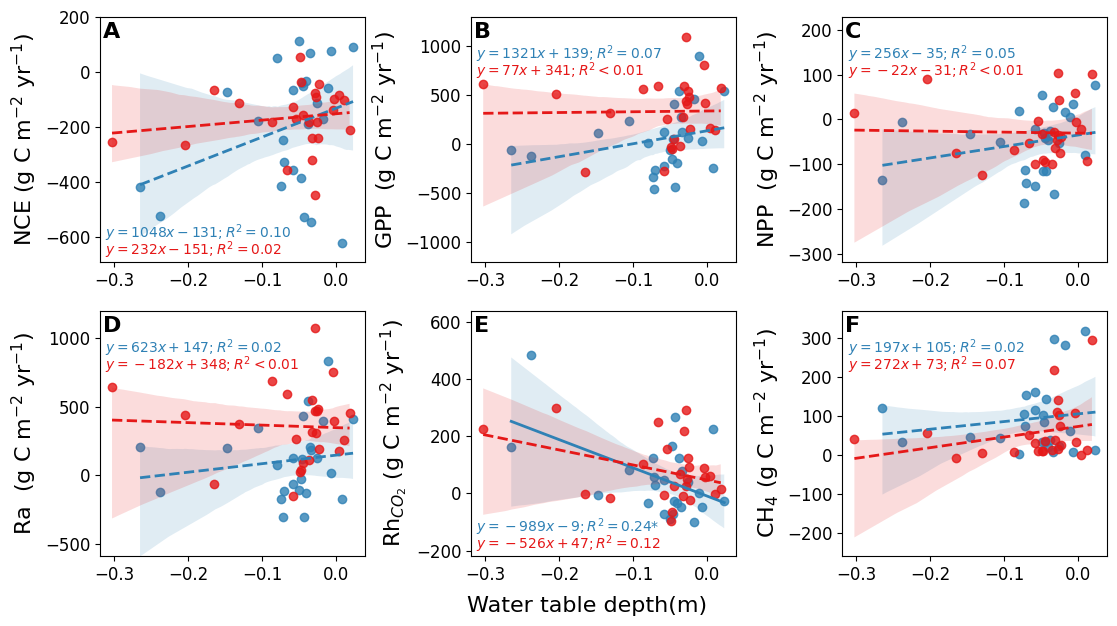

In [2]:
# relationship between water table and carbon fluxes

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import ttest_rel

import statsmodels.api as sm
import statsmodels.formula.api as smf

def cal_reg_diff(x1, y1, x2, y2): # justify if there is significant difference between two groups data
    # create two group datasets
    x = np.concatenate([x1, x2])
    y = np.concatenate([y1, y2])
    group = np.array([1]*len(x1) + [2]*len(x2))  # 1: group one; 2: group two

    # create a model include interactive object
    data = {'y': y, 'x': x, 'group': group}
    model = smf.ols('y ~ x + group + x * C(group)', data=data).fit()

    pvalue_diff_slope     = model.pvalues['x:C(group)[T.2]']
    pvalue_diff_intercept = model.pvalues['C(group)[T.2]']

    if pvalue_diff_slope < 0.05:
        res_ab_slope = ("a", "b")
    else:
        res_ab_slope = ("a", "a")

    if pvalue_diff_intercept < 0.05:
        res_ab_intercept = ("a", "b")
    else:
        res_ab_intercept = ("a", "a")

    return res_ab_slope, res_ab_intercept

# load data
df_all_yr = pd.read_parquet("5_water_table/water_table_all_yr_minus_2013.parquet")
df_all_yr_used = df_all_yr[df_all_yr["year"]>2016].copy().reset_index()
mapping = {
    "P06": 0, "P20": 2.25, "P13":4.5, "P08":6.75, "P17":9,
    "P19": 0, "P11": 2.25, "P04":4.5, "P16":6.75, "P10":9
}

df_all_yr_used["warming"] = df_all_yr_used["plot"].map(mapping)

ls_aco2_plots = ["P06", "P20", "P13", "P08", "P17"]
ls_eco2_plots = ["P19", "P11", "P04", "P16", "P10"]
ls_warmings   = [0,     2.25,  4.5,   6.75,  9]

fig, axes = plt.subplots(2, 3, figsize=(13,7))#, sharex=True)

ls_vars = ["nce", "gpp", "npp", "ra", "rh", "CH4"]
ls_subtitles = ["A", "B", "C",
                "D",  "E", "F"]

ls_ylabels = ["NCE (g C m$^{-2}$ yr$^{-1}$)", 
              "GPP  (g C m$^{-2}$ yr$^{-1}$)", 
              "NPP  (g C m$^{-2}$ yr$^{-1}$)",
              "Ra  (g C m$^{-2}$ yr$^{-1}$)", 
              "Rh$_{CO_2}$ (g C m$^{-2}$ yr$^{-1}$)", 
              "CH$_4$ (g C m$^{-2}$ yr$^{-1}$)"]

ls_x = df_all_yr_used["zwt"+"_diff"].values


ls_lims = [(-689, 200),  (-1199, 1299), (-319, 229),
           (-589, 1199), (-219, 639),  (-259, 369)]

ls_pox  = [(0.02, 0.1),  (0.02, 0.83), (0.02, 0.83),
           (0.02, 0.83), (0.02, 0.1),  (0.02, 0.83)]

ls_colors = ["#2F81B5", "#E51818"]
for idx_ax, ax in enumerate(axes.flatten()):
    ivar = ls_vars[idx_ax]
    for idx_co2, ls_plot in enumerate([ls_aco2_plots, ls_eco2_plots]):
        df_all_plot = df_all_yr_used[df_all_yr_used["plot"].isin(ls_plot)].copy()
        # ----------------------------------------
        ls_x = df_all_plot["zwt"+"_diff"].values
        ls_y = df_all_plot[ivar+"_diff"].values
        # ----------------------------------------
        slope, intercept, r, p, stderr = linregress(ls_x, ls_y)
        line_style = "-" if p < 0.05 else "--"
        sns.regplot(x=ls_x, y=ls_y, #order=2,
                scatter_kws={"color": ls_colors[idx_co2], "alpha": 0.8}, ax=ax, label="Ambient CO$_2$",
                line_kws={"color": ls_colors[idx_co2], "linestyle": line_style, "linewidth": 2})
        mark = "+" if intercept>0 else "-"
        intercept_val = intercept if intercept>0 else -intercept
        mark_p = ""
        if p < 0.001:
            mark_p = "***"
        elif p<0.01:
            mark_p = "**"
        elif p <0.05:
            mark_p = "*"
        if p<0.05:
            if r*r < 0.01:
                equation = f"$y = {slope:.0f}x {mark} {intercept_val:.0f}; R^2<0.01$"+mark_p#(rf"$^{{{mark_p}}}$" if mark_p else "")
            else:
                equation = f"$y = {slope:.0f}x {mark} {intercept_val:.0f}; R^2={r*r:.2f}$"+mark_p#(rf"$^{{{mark_p}}}$" if mark_p else "")
        else:
            if r*r < 0.01:
                equation = f"$y = {slope:.0f}x {mark} {intercept_val:.0f}; R^2<0.01$"
            else:    
                equation = f"$y = {slope:.0f}x {mark} {intercept_val:.0f}; R^2={r*r:.2f}$"
        ax.text(ls_pox[idx_ax][0], ls_pox[idx_ax][1]-idx_co2*0.07, equation, fontsize=10, transform=ax.transAxes, color = ls_colors[idx_co2])
        ax.set_ylim(ls_lims[idx_ax])
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.text(0.01,0.98,ls_subtitles[idx_ax], va="top", ha="left", transform=ax.transAxes, fontsize=16, fontweight="bold")
    ax.set_ylabel(ls_ylabels[idx_ax], fontsize=16)

fig.text(0.5, 0.03, 'Water table depth(m)', ha='center', fontsize=16)
# fig.text(0.05, 0.5, 'g C m$^{-2}$ yr$^{-1}$', va='center', rotation='vertical', fontsize=16)

plt.subplots_adjust(hspace=0.2, wspace=0.4)
# plt.savefig("2_results/5_figures/fig_r1_water_table.pdf", dpi=300, format="pdf", bbox_inches='tight')
